## Условие задания:
Необходимо построить модель отбора наиболее качественного вина для покупки. Качественным вином считаем вино качеством 7 и более.

Нужно решить какую меру качества выбрать, оптимизировать параметры модели.


## Выполнил - Алтухов Даниил

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pandas.plotting as pd_plt
import matplotlib.colors as plt_colors
from IPython.display import display


from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold 
from sklearn.neighbors import KNeighborsClassifier 

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV # решетчачытый поиск


from sklearn import set_config
set_config(display = "diagram")

In [2]:
wine_train = pd.read_csv("train.csv")
wine_train['quality'] = np.where(wine_train['quality'] >= 7, 1, 0) # вино качественное если качество 7 и больше (1 - качественное 0 - некачественное)
wine_train.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.550,0.19,1.8,0.082,15.0,34.0,0.99655,3.49,0.68,10.5,0
1,8.8,0.310,0.40,2.8,0.109,7.0,16.0,0.99614,3.31,0.79,11.8,1
2,6.9,0.540,0.30,2.2,0.088,9.0,105.0,0.99725,3.25,1.18,10.5,0
3,10.1,0.935,0.22,3.4,0.105,11.0,86.0,1.00100,3.43,0.64,11.3,0
4,9.9,0.540,0.45,2.3,0.071,16.0,40.0,0.99910,3.39,0.62,9.4,0


In [3]:
X = wine_train.iloc[:,:-1].values
y = wine_train.iloc[:, -1].values

display(X)
display(y)

array([[ 7.4 ,  0.55,  0.19, ...,  3.49,  0.68, 10.5 ],
       [ 8.8 ,  0.31,  0.4 , ...,  3.31,  0.79, 11.8 ],
       [ 6.9 ,  0.54,  0.3 , ...,  3.25,  1.18, 10.5 ],
       ...,
       [ 7.2 ,  0.37,  0.32, ...,  3.23,  0.73, 11.3 ],
       [ 8.8 ,  0.61,  0.14, ...,  3.19,  0.59,  9.5 ],
       [12.  ,  0.39,  0.66, ...,  3.18,  0.63, 10.8 ]])

array([0, 1, 0, ..., 1, 0, 1])

In [11]:
# Строим pipeline (осуществим решетчатый поиск)
# 1. Посмотрим какой препроцессинг лучше
# 2. Будем менять количсетво ближайших соседей и изменять то, каким образом будем измерять между ними расстояние
# 3. Будем валидировать 

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 56, test_size = 0.25, stratify = y)

kfold = KFold(n_splits = 10, shuffle = True)
pipe = Pipeline([('preprocessing', MinMaxScaler()),
                 ('classifier', KNeighborsClassifier())])


n_neighbors = np.arange(5, 35)
weights = ['uniform', 'distance'] # штраф на расстояние 

# делаем решетку ParamGrid

param_grid = [
    {'preprocessing': [MinMaxScaler(), StandardScaler(), RobustScaler(), Normalizer()],
    'classifier': [KNeighborsClassifier()],
    'classifier__n_neighbors': n_neighbors,  
    'classifier__p': p,
    'classifier__weights': weights
    }
]


grid = GridSearchCV(pipe, param_grid , cv = kfold, return_train_score = True, n_jobs = -1)
grid.fit(X_train, y_train)

print("------------------ Обучили и тестировали ------------------")
print("Индекс лучшего результата:\n{}".format(grid.best_index_))
print("--------------------------------------------------------")
print("Словарь с наилучшими параметры: \n{}\n ".format(grid.best_params_))
print("--------------------------------------------------------")
print("Средняя правильность для наилучшей модели кроссвалидации на валидационных поверочных наборах: {:.6f}\n".format(grid.best_score_))
print("--------------------------------------------------------")
print("Правильность для наилучшей модели на тестовом наборе: {:.6f}\n".format(grid.score(X_test, y_test)))
print("--------------------------------------------------------")
print("Настройки лучшей модели в контейнере:\n{}\n".format(grid.best_estimator_))



------------------ Обучили и тестировали ------------------
Индекс лучшего результата:
596
--------------------------------------------------------
Словарь с наилучшими параметры: 
{'classifier': KNeighborsClassifier(n_neighbors=23, p=3, weights='distance'), 'classifier__n_neighbors': 23, 'classifier__p': 3, 'classifier__weights': 'distance', 'preprocessing': MinMaxScaler()}
 
--------------------------------------------------------
Средняя правильность для наилучшей модели кроссвалидации на валидационных поверочных наборах: 0.907678

--------------------------------------------------------
Правильность для наилучшей модели на тестовом наборе: 0.880000

--------------------------------------------------------
Настройки лучшей модели в контейнере:
Pipeline(steps=[('preprocessing', MinMaxScaler()),
                ('classifier',
                 KNeighborsClassifier(n_neighbors=23, p=3,
                                      weights='distance'))])



In [12]:
gridresults = pd.DataFrame(grid.cv_results_)
display(gridresults.sort_values(["rank_test_score"]).T)
display(gridresults[gridresults['rank_test_score'] == 1].sort_index())

,596,628,861,565,701,893,765,957,533,733,...,211,18,91,51,43,83,75,27,11,19
mean_fit_time,0.002224,0.002698,0.003377,0.003773,0.003091,0.002911,0.00289,0.002915,0.002466,0.002952,...,0.003451,0.00696,0.002584,0.002065,0.002208,0.002622,0.002653,0.002298,0.002685,0.002576
std_fit_time,0.000423,0.00072,0.001604,0.002219,0.000788,0.000513,0.000312,0.000523,0.000243,0.000533,...,0.001854,0.001395,0.000885,0.000145,0.000042,0.00086,0.001008,0.000533,0.000471,0.00067
mean_score_time,0.036531,0.042626,0.046882,0.048819,0.047254,0.055498,0.049172,0.046313,0.048373,0.046615,...,0.018823,0.041349,0.015511,0.014202,0.007579,0.016827,0.008677,0.014099,0.007706,0.015529
std_score_time,0.001398,0.006837,0.004672,0.004213,0.004983,0.004109,0.004316,0.00393,0.004635,0.001987,...,0.002038,0.005292,0.002188,0.001273,0.001832,0.002716,0.002849,0.002204,0.002709,0.002048
param_classifier,"KNeighborsClassifier(n_neighbors=23, p=3, weig...","KNeighborsClassifier(n_neighbors=23, p=3, weig...","KNeighborsClassifier(n_neighbors=23, p=3, weig...","KNeighborsClassifier(n_neighbors=23, p=3, weig...","KNeighborsClassifier(n_neighbors=23, p=3, weig...","KNeighborsClassifier(n_neighbors=23, p=3, weig...","KNeighborsClassifier(n_neighbors=23, p=3, weig...","KNeighborsClassifier(n_neighbors=23, p=3, weig...","KNeighborsClassifier(n_neighbors=23, p=3, weig...","KNeighborsClassifier(n_neighbors=23, p=3, weig...",...,"KNeighborsClassifier(n_neighbors=23, p=3, weig...","KNeighborsClassifier(n_neighbors=23, p=3, weig...","KNeighborsClassifier(n_neighbors=23, p=3, weig...","KNeighborsClassifier(n_neighbors=23, p=3, weig...","KNeighborsClassifier(n_neighbors=23, p=3, weig...","KNeighborsClassifier(n_neighbors=23, p=3, weig...","KNeighborsClassifier(n_neighbors=23, p=3, weig...","KNeighborsClassifier(n_neighbors=23, p=3, weig...","KNeighborsClassifier(n_neighbors=23, p=3, weig...","KNeighborsClassifier(n_neighbors=23, p=3, weig..."
param_classifier__n_neighbors,23,24,31,22,26,32,28,34,21,27,...,11,5,7,6,6,7,7,5,5,5
param_classifier__p,3,3,5,3,5,5,5,5,3,5,...,3,3,5,3,2,3,2,5,2,3
param_classifier__weights,distance,distance,distance,distance,distance,distance,distance,distance,distance,distance,...,uniform,uniform,uniform,uniform,uniform,uniform,uniform,uniform,uniform,uniform
param_preprocessing,MinMaxScaler(),MinMaxScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),...,Normalizer(),RobustScaler(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer()
params,{'classifier': KNeighborsClassifier(n_neighbor...,{'classifier': KNeighborsClassifier(n_neighbor...,{'classifier': KNeighborsClassifier(n_neighbor...,{'classifier': KNeighborsClassifier(n_neighbor...,{'classifier': KNeighborsClassifier(n_neighbor...,{'classifier': KNeighborsClassifier(n_neighbor...,{'classifier': KNeighborsClassifier(n_neighbor...,{'classifier': KNeighborsClassifier(n_neighbor...,{'classifier': KNeighborsClassifier(n_neighbor...,{'classifier': KNeighborsClassifier(n_neighbor...,...,{'classifier': KNeighborsClassifier(n_neighbor...,{'classifier': KNeighborsClassifier(n_neighbor...,{'classifier': KNeighborsClassifier(n_neighbor...,{'classifier': KNeighborsClassifier(n_neighbor...,{'classifier': KNeighborsClassifier(n_neighbor...,{'classifier': KNeighborsClassifier(n_neighbor...,{'classifier': KNeighborsClassifier(n_neighbor...,{'classifier': KNeighborsClassifier(n_neighbor...,{'classifier': KNeighborsClassifier(n_neighbor...,{'classifier': KNeighborsClassifier(n_neighbor...


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__n_neighbors,param_classifier__p,param_classifier__weights,param_preprocessing,params,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
596,0.002224,0.000423,0.036531,0.001398,"KNeighborsClassifier(n_neighbors=23, p=3, weig...",23,3,distance,MinMaxScaler(),{'classifier': KNeighborsClassifier(n_neighbor...,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [13]:
res = gridresults.sort_values(["rank_test_score"])
res[res['rank_test_score'] == 1].sort_index() # модель с наилучшим рангом

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__n_neighbors,param_classifier__p,param_classifier__weights,param_preprocessing,params,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
596,0.002224,0.000423,0.036531,0.001398,"KNeighborsClassifier(n_neighbors=23, p=3, weig...",23,3,distance,MinMaxScaler(),{'classifier': KNeighborsClassifier(n_neighbor...,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [14]:
res['rank_test_score'].unique() # ранговые значения

array([  1,   2,   5,   9,  10,  14,  18,  19,  23,  26,  27,  28,  30,
        35,  39,  43,  47,  63,  73,  75,  76,  84,  88,  93,  96, 101,
       112, 116, 118, 119, 121, 127, 138, 148, 149, 150, 151, 154, 161,
       166, 168, 169, 174, 183, 196, 200, 201, 211, 221, 222, 225, 227,
       228, 235, 244, 245, 246, 247, 257, 267, 271, 273, 281, 286, 288,
       292, 301, 326, 329, 330, 335, 357, 358, 363, 364, 365, 369, 379,
       384, 386, 387, 388, 390, 399, 405, 407, 409, 412, 415, 416, 417,
       419, 427, 428, 433, 438, 439, 440, 444, 450, 451, 457, 460, 461,
       462, 470, 475, 476, 479, 486, 494, 495, 496, 497, 499, 507, 514,
       517, 518, 519, 523, 534, 540, 542, 544, 551, 556, 563, 564, 566,
       573, 579, 583, 585, 586, 594, 603, 611, 612, 613, 615, 616, 627,
       637, 641, 643, 645, 647, 648, 651, 662, 671, 677, 678, 679, 680,
       682, 690, 698, 700, 703, 707, 708, 709, 711, 722, 724, 727, 729,
       730, 739, 740, 747, 748, 752, 753, 756, 762, 763, 776, 77

In [15]:
grid.cv_results_['params'][grid.best_index_]

{'classifier': KNeighborsClassifier(n_neighbors=23, p=3, weights='distance'),
 'classifier__n_neighbors': 23,
 'classifier__p': 3,
 'classifier__weights': 'distance',
 'preprocessing': MinMaxScaler()}

In [16]:
from joblib import Memory
memory = Memory()


preproc_1, model_1 = map(grid.cv_results_['params'][71].get, ['preprocessing','classifier'])

pipe_best = make_pipeline(preproc_1, model_1, memory = memory)
pipe_best.fit(X_train, y_train)
y_best = pipe_best.predict(X_test)


display(pipe_best.score(X_train, y_train))
display(pipe_best.score(X_test, y_test))
pipe_best

1.0

0.8733333333333333

Pipeline(memory=Memory(location=None),
         steps=[('normalizer', Normalizer()),
                ('kneighborsclassifier',
                 KNeighborsClassifier(n_neighbors=23, p=3,
                                      weights='distance'))])

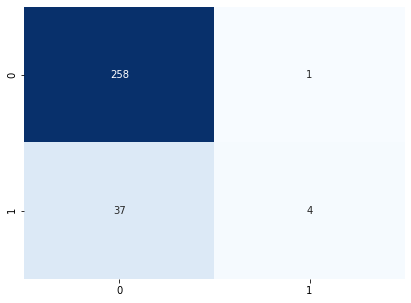

In [17]:
from sklearn.metrics import confusion_matrix

matrix_1 = confusion_matrix(y_test,y_best)


fig,ax = plt.subplots(1,  sharex = True, sharey = True, figsize = (15,5))
ax = plt.subplot(1, 2, 1)
sns.heatmap(matrix_1,annot = True, fmt = 'g', cbar = None,cmap = "Blues");


In [18]:
from sklearn.metrics import f1_score

print ( 'лучшая ', f1_score(y_test, y_best) )

лучшая  0.1739130434782609


In [19]:
best_model = grid.best_estimator_
grid.best_estimator_

Pipeline(steps=[('preprocessing', MinMaxScaler()),
                ('classifier',
                 KNeighborsClassifier(n_neighbors=23, p=3,
                                      weights='distance'))])

In [20]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_best))


              precision    recall  f1-score   support

           0       0.87      1.00      0.93       259
           1       0.80      0.10      0.17        41

    accuracy                           0.87       300
   macro avg       0.84      0.55      0.55       300
weighted avg       0.86      0.87      0.83       300



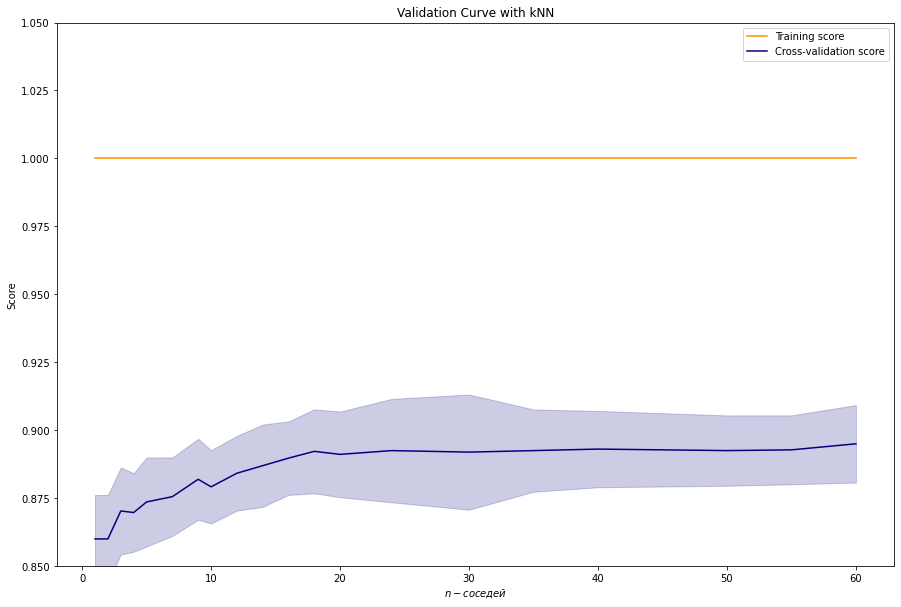

In [21]:
from sklearn.model_selection import validation_curve
from sklearn.model_selection import StratifiedShuffleSplit

pipe_gs = best_model

n_range = [1, 2, 3, 4, 5, 7, 9, 10, 12, 14, 16, 18, 20, 24, 30, 35, 40, 50, 55, 60]
train_scores, test_scores = validation_curve(
    pipe_gs, X_train, y_train,
    param_name="classifier__n_neighbors", 
    param_range=n_range,
    cv=StratifiedShuffleSplit(n_splits=20,  test_size=0.2, train_size=0.7, random_state=2), 
    scoring="accuracy", 
    n_jobs=-1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(15,10))

plt.title("Validation Curve with kNN")
plt.xlabel("$n-соседей$")
plt.ylabel("Score")
plt.ylim(0.85, 1.05)

plt.plot(n_range, train_scores_mean, label="Training score", color="darkorange")
plt.fill_between(n_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange")
plt.plot(n_range, test_scores_mean, label = "Cross-validation score",
             color="navy")
plt.fill_between(n_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha = 0.2,
                 color="navy")

plt.legend(loc="best")
plt.show()

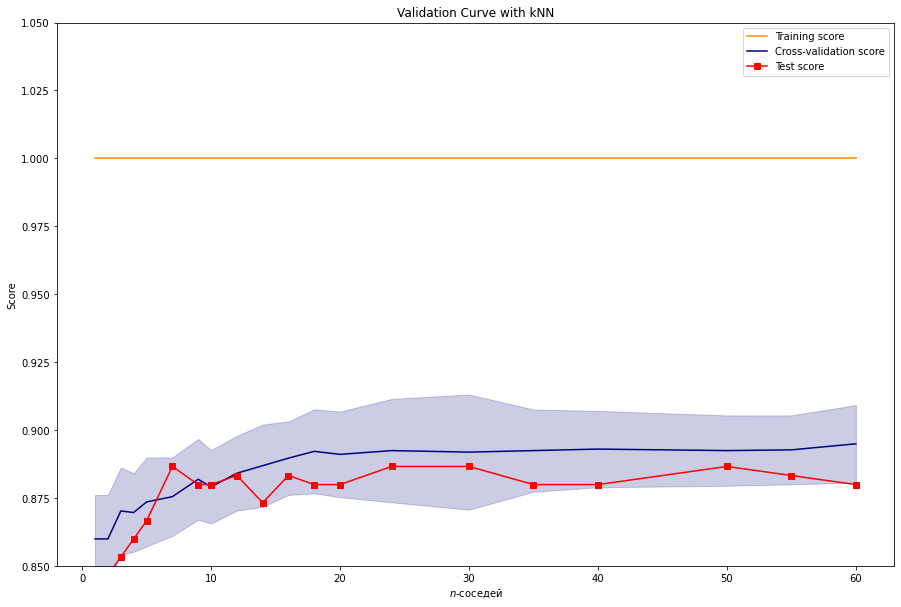

In [22]:
pipe_gs = grid.best_estimator_

n_range = [1,2,3,4,5,7,9,10,12,14,16,18,20,24,30,35,40,50,55,60]
train_scores, test_scores = validation_curve(
    pipe_gs, X_train, y_train,
    param_name="classifier__n_neighbors", 
    param_range=n_range,
    cv=StratifiedShuffleSplit(n_splits=20,  test_size=0.2, train_size=0.7, random_state=2), 
    scoring="accuracy", 
    n_jobs=-1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)


test_sc=[]
for n in n_range:
    pipe_gs.set_params(classifier__n_neighbors = n)
    test_sc.append(pipe_gs.score(X_test , y_test))

plt.figure(figsize=(15,10))

plt.title("Validation Curve with kNN")
plt.xlabel("$n$-соседей")
plt.ylabel("Score")
plt.ylim(0.85, 1.05)

plt.plot(n_range, train_scores_mean, label="Training score", color="darkorange")
plt.fill_between(n_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange")
plt.plot(n_range, test_scores_mean, label="Cross-validation score",
             color="navy")
plt.fill_between(n_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy")

plt.plot(n_range, test_sc, label="Test score", color="red", marker="s")

plt.legend(loc="best")
plt.show()

In [26]:
# Создаем контейнер содержащий итоговую модель

pipeline_final = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors = 27, weights = 'distance', p = 3))
wine_test = pd.read_csv("test.csv")
pipeline_final.fit(X_train, y_train)
y_predict = pipeline_final.predict(wine_test)

/Users/daniil/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [34]:
test_123 = pd.DataFrame(y_predict)
print(test_123[test_123[0] == 1])

     0
9    1
14   1
22   1
43   1
70   1
77   1
98   1
116  1
125  1
129  1
177  1
190  1
202  1
209  1
228  1
232  1
256  1
271  1
290  1
292  1
297  1
302  1
303  1
327  1
329  1
378  1
386  1
388  1
394  1
